# Project 1

*Elżbieta Jowik*

*Agata Makarewicz*

In [1]:
# imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings(action='ignore')

pd.options.display.max_columns = None
plt.rcParams['figure.figsize'] = (9, 6)

In [2]:
# functions
def count_missings(df: pd.DataFrame) -> pd.DataFrame:
    """
    Function for counting the number and percentage of missing values in each column of the data frame,
    sorting it in descending order.

    Args:
        df (pd.DataFrame): Data frame in which missing values are to be inspected.

    Returns:
        pd.DataFrame: Data frame containg missing values number and percentage for each of the columns
                        in the input data frame. 
    """
    total = df.isna().sum().sort_values(ascending=False) # how many missings in each column
    percent = ((df.isna().sum()/df.isna().count())*100).sort_values(ascending=False).round(2) # in %
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data = missing_data.rename_axis('Column').reset_index()
    return missing_data[missing_data.Total>0]

## Part 1

In [3]:
# reading the data
data_adult = pd.read_csv('datasets/project1/adult.csv', na_values=" ?")
data_credit = pd.read_csv('datasets/project1/credit.csv') # no missing values
data_sick = pd.read_csv('datasets/project1/sick.csv', na_values="?")
data_titanic = pd.read_csv('datasets/project1/titanic.csv', na_values="?")

### Adult dataset

In [4]:
data_adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


In [5]:
data_adult.shape

(48842, 15)

In [6]:
data_adult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       46043 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      46033 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  47985 non-null  object
 14  class           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [7]:
data_adult.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [8]:
data_adult.duplicated().value_counts()

False    48790
True        52
dtype: int64

In [9]:
data_adult = data_adult.drop_duplicates()

In [10]:
# removing leading whitespaces
data_adult = data_adult.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [11]:
count_missings(data_adult)

,Column,Total,Percent
0,occupation,2805,5.75
1,workclass,2795,5.73
2,native-country,856,1.75


<AxesSubplot:>

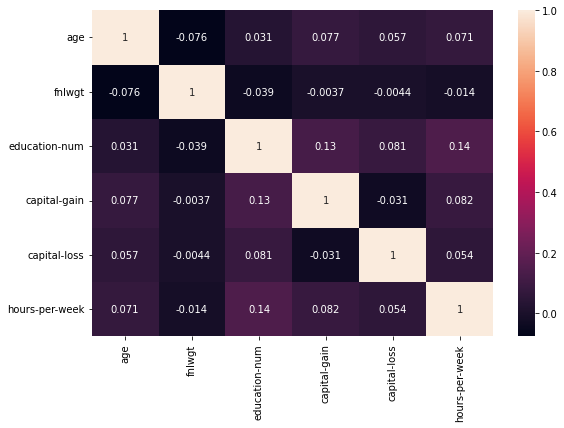

In [12]:
corr = data_adult.corr()
sns.heatmap(corr, annot=True) # no collinear features

In [13]:
# encoding the target variable
# data_adult.loc[data_adult['class'] == '<=50K', 'class'] = 0
# data_adult.loc[data_adult['class'] == '>50K', 'class'] = 1
data_adult.rename(columns={'class':'target'}, inplace=True)

In [14]:
data_adult.drop(['education'], axis=1, inplace=True)

In [15]:
data_adult['native-country'] = data_adult['native-country'].fillna('other')
vc = data_adult['native-country'].value_counts()
data_adult['native-country'] = data_adult['native-country'].apply(lambda x: x if vc[x]>=100 else "other")

In [16]:
one_hot_cols = data_adult.select_dtypes(np.object).columns.drop(['sex', 'target'])
num_cols = data_adult.select_dtypes('number').columns
bin_cols = ['sex']

In [18]:
num_pipe = Pipeline([
    # ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
bin_pipe = Pipeline([
    # ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder()), # will work as binary
])
one_hot_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

pipe = ColumnTransformer(transformers=[
    ('bin', bin_pipe, bin_cols),
    ('num', num_pipe, num_cols),
    ('one', one_hot_pipe, one_hot_cols)
])

In [19]:
# adjust the split to take the imbalance into account - stratify option; 75/25 ratio
data_adult_train, data_adult_test, target_adult_train, target_adult_test = train_test_split(data_adult, 
                                                                                            data_adult.target, 
                                                                                            stratify=data_adult.target, 
                                                                                            test_size=0.25, 
                                                                                            random_state=1)

In [20]:
data_adult_train = pd.DataFrame(pipe.fit_transform(data_adult_train).toarray())
data_adult_test = pd.DataFrame(pipe.transform(data_adult_test).toarray())

target_adult_train = pd.Series(target_adult_train)
target_adult_test = pd.Series(target_adult_test)

one_hot_names = pipe.named_transformers_['one']['encoder'].get_feature_names()
for i in range(len(one_hot_names)):
    one_hot_names[i] = one_hot_names[i].replace('x0','workclass')
    one_hot_names[i] = one_hot_names[i].replace('x1','marital-status')
    one_hot_names[i] = one_hot_names[i].replace('x2','occupation')
    one_hot_names[i] = one_hot_names[i].replace('x3','relationship')
    one_hot_names[i] = one_hot_names[i].replace('x4','race')
    one_hot_names[i] = one_hot_names[i].replace('x5','native-country')
    one_hot_names[i] = one_hot_names[i].replace(' ','_')
    
column_names = list(bin_cols) + num_cols.to_list() + list(one_hot_names)
data_adult_train.columns = column_names
data_adult_test.columns = column_names

### German Credit Dataset

In [21]:
data_credit.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,'<0',6,'critical/other existing credit',radio/tv,1169,'no known savings','>=7',4,'male single',none,4,'real estate',67,none,own,2,skilled,1,yes,yes,good
1,'0<=X<200',48,'existing paid',radio/tv,5951,'<100','1<=X<4',2,'female div/dep/mar',none,2,'real estate',22,none,own,1,skilled,1,none,yes,bad
2,'no checking',12,'critical/other existing credit',education,2096,'<100','4<=X<7',2,'male single',none,3,'real estate',49,none,own,1,'unskilled resident',2,none,yes,good
3,'<0',42,'existing paid',furniture/equipment,7882,'<100','4<=X<7',2,'male single',guarantor,4,'life insurance',45,none,'for free',1,skilled,2,none,yes,good
4,'<0',24,'delayed previously','new car',4870,'<100','1<=X<4',3,'male single',none,4,'no known property',53,none,'for free',2,skilled,2,none,yes,bad


In [22]:
data_credit.shape

(1000, 21)

In [23]:
data_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   checking_status         1000 non-null   object
 1   duration                1000 non-null   int64 
 2   credit_history          1000 non-null   object
 3   purpose                 1000 non-null   object
 4   credit_amount           1000 non-null   int64 
 5   savings_status          1000 non-null   object
 6   employment              1000 non-null   object
 7   installment_commitment  1000 non-null   int64 
 8   personal_status         1000 non-null   object
 9   other_parties           1000 non-null   object
 10  residence_since         1000 non-null   int64 
 11  property_magnitude      1000 non-null   object
 12  age                     1000 non-null   int64 
 13  other_payment_plans     1000 non-null   object
 14  housing                 1000 non-null   object
 15  exist

In [24]:
data_credit.describe()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


In [25]:
data_credit.duplicated().value_counts()

False    1000
dtype: int64

In [26]:
# removing unnecessary quotes
data_credit = data_credit.apply(lambda x: x.str.replace("'", "") if x.dtype == "object" else x)

In [27]:
count_missings(data_credit) 

,Column,Total,Percent


<AxesSubplot:>

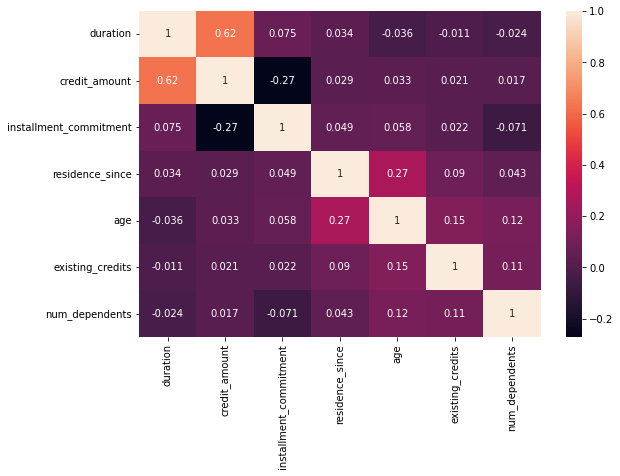

In [28]:
corr = data_credit.corr()
sns.heatmap(corr, annot=True)

In [29]:
# encoding the target variable
# data_credit.loc[data_credit['class'] == 'good', 'class'] = 0
# data_credit.loc[data_credit['class'] == 'bad', 'class'] = 1
data_credit.rename(columns={'class':'target'}, inplace=True)

In [30]:
one_hot_cols = data_credit.select_dtypes(np.object).columns.drop(['own_telephone', 'foreign_worker', 'target'])
num_cols = data_credit.select_dtypes('number').columns
bin_cols = ['own_telephone', 'foreign_worker']

In [31]:
num_pipe = Pipeline([
    # ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
bin_pipe = Pipeline([
    # ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder()), # will work as binary
])
one_hot_pipe = Pipeline([
    # ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

pipe = ColumnTransformer(transformers=[
    ('bin', bin_pipe, bin_cols),
    ('num', num_pipe, num_cols),
    ('one', one_hot_pipe, one_hot_cols)
])

In [32]:
# adjust the split to take the imbalance into account - stratify option; 75/25 ratio
data_credit_train, data_credit_test, target_credit_train, target_credit_test = train_test_split(data_credit, 
                                                                                                data_credit.target, 
                                                                                                stratify=data_credit.target, 
                                                                                                test_size=0.25, 
                                                                                                random_state=1)

In [33]:
data_credit_train = pd.DataFrame(pipe.fit_transform(data_credit_train))
data_credit_test = pd.DataFrame(pipe.transform(data_credit_test))

target_credit_train = pd.Series(target_credit_train)
target_credit_test = pd.Series(target_credit_test)

one_hot_names = pipe.named_transformers_['one']['encoder'].get_feature_names()
for i in range(len(one_hot_names)):
    one_hot_names[i] = one_hot_names[i].replace('x0','checking_status')
    one_hot_names[i] = one_hot_names[i].replace('x1','credit_history')
    one_hot_names[i] = one_hot_names[i].replace('x2','purpose')
    one_hot_names[i] = one_hot_names[i].replace('x3','savings_status')
    one_hot_names[i] = one_hot_names[i].replace('x4','employment')
    one_hot_names[i] = one_hot_names[i].replace('x5','personal_status')
    one_hot_names[i] = one_hot_names[i].replace('x6','other_parties')
    one_hot_names[i] = one_hot_names[i].replace('x7','property_magnitude')
    one_hot_names[i] = one_hot_names[i].replace('x8','other_payment_plans')
    one_hot_names[i] = one_hot_names[i].replace('x9','housing')
    one_hot_names[i] = one_hot_names[i].replace('x10','job')
    one_hot_names[i] = one_hot_names[i].replace(' ','_')
    
column_names = list(bin_cols) + num_cols.to_list() + list(one_hot_names)
data_credit_train.columns = column_names
data_credit_test.columns = column_names

### Sick dataset

In [34]:
data_sick.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.30,t,2.5,t,125.0,t,1.14,t,109.0,f,NaN,SVHC,negative
1,23.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,4.10,t,2.0,t,102.0,f,NaN,f,NaN,f,NaN,other,negative
2,46.0,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.98,f,NaN,t,109.0,t,0.91,t,120.0,f,NaN,other,negative
3,70.0,F,t,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.16,t,1.9,t,175.0,f,NaN,f,NaN,f,NaN,other,negative
4,70.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.72,t,1.2,t,61.0,t,0.87,t,70.0,f,NaN,SVI,negative


In [35]:
data_sick.shape

(3772, 30)

In [36]:
data_sick.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        3771 non-null   float64
 1   sex                        3622 non-null   object 
 2   on_thyroxine               3772 non-null   object 
 3   query_on_thyroxine         3772 non-null   object 
 4   on_antithyroid_medication  3772 non-null   object 
 5   sick                       3772 non-null   object 
 6   pregnant                   3772 non-null   object 
 7   thyroid_surgery            3772 non-null   object 
 8   I131_treatment             3772 non-null   object 
 9   query_hypothyroid          3772 non-null   object 
 10  query_hyperthyroid         3772 non-null   object 
 11  lithium                    3772 non-null   object 
 12  goitre                     3772 non-null   object 
 13  tumor                      3772 non-null   objec

In [37]:
data_sick.describe() # age=455 not possible

,age,TSH,T3,TT4,T4U,FTI,TBG
count,3771.000000,3403.000000,3003.000000,3541.000000,3385.000000,3387.000000,0.0
mean,51.735879,5.086766,2.013500,108.319345,0.995000,110.469649,NaN
std,20.084958,24.521470,0.827434,35.604248,0.195457,33.089698,NaN
min,1.000000,0.005000,0.050000,2.000000,0.250000,2.000000,NaN
25%,36.000000,0.500000,1.600000,88.000000,0.880000,93.000000,NaN
50%,54.000000,1.400000,2.000000,103.000000,0.980000,107.000000,NaN
75%,67.000000,2.700000,2.400000,124.000000,1.080000,124.000000,NaN
max,455.000000,530.000000,10.600000,430.000000,2.320000,395.000000,NaN


In [38]:
# dropping obvious outliers and non-informative columns
data_sick = data_sick[data_sick.age != 455].drop(['TBG', 'TBG_measured'], axis=1)

In [39]:
data_sick.duplicated().value_counts()

False    3710
True       61
dtype: int64

In [40]:
data_sick = data_sick.drop_duplicates()

In [41]:
count_missings(data_sick)

,Column,Total,Percent
0,T3,709,19.11
1,T4U,327,8.81
2,FTI,325,8.76
3,TSH,309,8.33
4,TT4,171,4.61
5,sex,149,4.02
6,age,1,0.03


<AxesSubplot:>

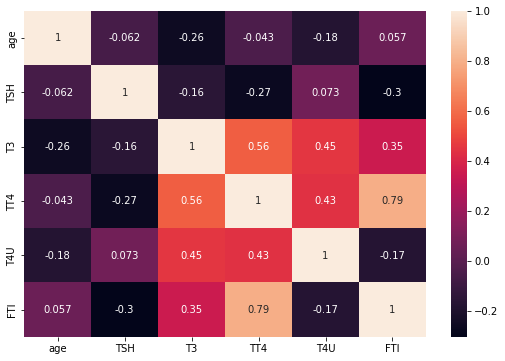

In [42]:
corr = data_sick.corr()
sns.heatmap(corr, annot=True)

In [43]:
# encoding the target variable
# data_sick.loc[data_sick['Class'] == 'negative', 'Class'] = 0
# data_sick.loc[data_sick['Class'] == 'positive', 'Class'] = 1
data_sick.rename(columns={'Class':'target'}, inplace=True)

In [44]:
data_sick = data_sick.drop(['TSH_measured', 'T3_measured', 'TT4_measured','T4U_measured', 'FTI_measured'], axis=1)

In [45]:
one_hot_cols = ['referral_source', 'sex']
num_cols = data_sick.select_dtypes('number').columns
bin_cols = data_sick.select_dtypes(np.object).columns.drop(['referral_source', 'sex', 'target'])

In [46]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
bin_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder()), # will work as binary
])
one_hot_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

pipe = ColumnTransformer(transformers=[
    ('bin', bin_pipe, bin_cols),
    ('num', num_pipe, num_cols),
    ('one', one_hot_pipe, one_hot_cols)
])

In [47]:
# adjust the split to take the imbalance into account - stratify option; 75/25 ratio
data_sick_train, data_sick_test, target_sick_train, target_sick_test = train_test_split(data_sick, 
                                                                                        data_sick['target'], 
                                                                                        stratify=data_sick['target'], 
                                                                                        test_size=0.25, 
                                                                                        random_state=1)

In [48]:
data_sick_train = pd.DataFrame(pipe.fit_transform(data_sick_train))
data_sick_test = pd.DataFrame(pipe.transform(data_sick_test))

target_sick_train = pd.Series(target_sick_train)
target_sick_test = pd.Series(target_sick_test)

one_hot_names = pipe.named_transformers_['one']['encoder'].get_feature_names()
for i in range(len(one_hot_names)):
    one_hot_names[i] = one_hot_names[i].replace('x0','referral_source')
    one_hot_names[i] = one_hot_names[i].replace('x1','sex')
    
column_names = bin_cols.to_list() + num_cols.to_list() + list(one_hot_names)
data_sick_train.columns = column_names
data_sick_test.columns = column_names

### Titanic dataset

In [49]:
data_titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [50]:
data_titanic.shape

(1309, 14)

In [51]:
data_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


In [52]:
data_titanic.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


In [53]:
data_titanic.duplicated().value_counts()

False    1309
dtype: int64

In [54]:
count_missings(data_titanic)

,Column,Total,Percent
0,body,1188,90.76
1,cabin,1014,77.46
2,boat,823,62.87
3,home.dest,564,43.09
4,age,263,20.09
5,embarked,2,0.15
6,fare,1,0.08


<AxesSubplot:>

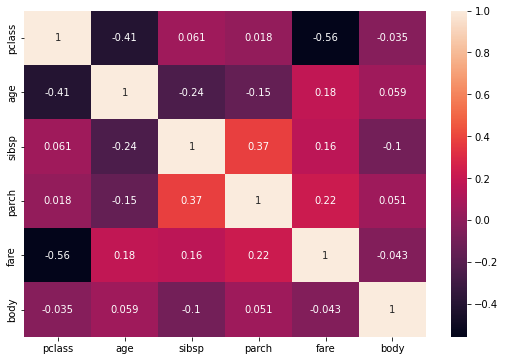

In [55]:
corr = data_titanic.drop('survived', axis=1).corr()
sns.heatmap(corr, annot=True)

In [56]:
data_titanic.survived[data_titanic.survived==0] = 'no'
data_titanic.survived[data_titanic.survived==1] = 'yes'
data_titanic.rename(columns={'survived':'target'}, inplace=True)

In [57]:
data_titanic.drop(['body', 'ticket', 'name'], axis=1, inplace=True)

In [58]:
data_titanic['cabin'].astype(str).str[0]
data_titanic['cabin'] = data_titanic['cabin'].fillna('Unknown')
data_titanic['cabin'] = data_titanic['cabin'].apply(lambda x: x if x == "Unknown" else x[0])

In [59]:
data_titanic.loc[data_titanic.boat.isna(), 'boat'] = 0
data_titanic.loc[data_titanic.boat != 0, 'boat'] = 1
data_titanic.boat = data_titanic.boat.astype(int)

In [60]:
data_titanic['home.dest'] = data_titanic['home.dest'].apply(lambda x: str(x).split(",")[-1].strip().split("/")[0])
vc = data_titanic['home.dest'].value_counts()
data_titanic['home.dest'] = data_titanic['home.dest'].apply(lambda x: x if vc[x]>=10 else "other")
data_titanic['home.dest'] = data_titanic['home.dest'].apply(lambda x: np.nan if x=='nan' else x)

In [61]:
one_hot_cols = data_titanic.select_dtypes(np.object).columns.drop(['sex', 'embarked', 'target'])
num_cols = data_titanic.select_dtypes('number').columns
bin_cols = ['sex', 'embarked']

In [62]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
bin_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder()), # will work as binary
])
one_hot_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

pipe = ColumnTransformer(transformers=[
    ('bin', bin_pipe, bin_cols),
    ('num', num_pipe, num_cols),
    ('one', one_hot_pipe, one_hot_cols)
])

In [63]:
# adjust the split to take the imbalance into account - stratify option; 75/25 ratio
data_titanic_train, data_titanic_test, target_titanic_train, target_titanic_test = train_test_split(data_titanic, 
                                                                                                    data_titanic.target, 
                                                                                                    stratify=data_titanic.target, 
                                                                                                    test_size=0.25, 
                                                                                                    random_state=1)

In [64]:
data_titanic_train = pd.DataFrame(pipe.fit_transform(data_titanic_train).toarray())
data_titanic_test = pd.DataFrame(pipe.transform(data_titanic_test).toarray())

target_titanic_train = pd.Series(target_titanic_train)
target_titanic_test = pd.Series(target_titanic_test)

one_hot_names = pipe.named_transformers_['one']['encoder'].get_feature_names()
for i in range(len(one_hot_names)):
    one_hot_names[i] = one_hot_names[i].replace('x0','cabin')
    one_hot_names[i] = one_hot_names[i].replace('x1','home.dest')
    
column_names = list(bin_cols) + num_cols.to_list() + list(one_hot_names)
data_titanic_train.columns = column_names
data_titanic_test.columns = column_names

In [72]:
# saving preprocessed datasets
data_adult_train.to_csv('datasets/project1/preprocessed/adult_train_x.csv', index=False)
data_adult_test.to_csv('datasets/project1/preprocessed/adult_test_x.csv', index=False)

data_credit_train.to_csv('datasets/project1/preprocessed/credit_train_x.csv', index=False)
data_credit_test.to_csv('datasets/project1/preprocessed/credit_test_x.csv', index=False)

data_sick_train.to_csv('datasets/project1/preprocessed/sick_train_x.csv', index=False)
data_sick_test.to_csv('datasets/project1/preprocessed/sick_test_x.csv', index=False)

data_titanic_train.to_csv('datasets/project1/preprocessed/titanic_train_x.csv', index=False)
data_titanic_test.to_csv('datasets/project1/preprocessed/titanic_test_x.csv', index=False)

In [75]:
# saving preprocessed datasets
target_adult_train.to_csv('datasets/project1/preprocessed/adult_train_y.csv', index=False)
target_adult_test.to_csv('datasets/project1/preprocessed/adult_test_y.csv', index=False)

target_credit_train.to_csv('datasets/project1/preprocessed/credit_train_y.csv', index=False)
target_credit_test.to_csv('datasets/project1/preprocessed/credit_test_y.csv', index=False)

target_sick_train.to_csv('datasets/project1/preprocessed/sick_train_y.csv', index=False)
target_sick_test.to_csv('datasets/project1/preprocessed/sick_test_y.csv', index=False)

target_titanic_train.to_csv('datasets/project1/preprocessed/titanic_train_y.csv', index=False)
target_titanic_test.to_csv('datasets/project1/preprocessed/titanic_test_y.csv', index=False)